# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Цель исследования**:
1. Описать поведение клиентов оператора, исходя из выборки.
2. Посчитать среднее количество минут разговора, сообщений и объёма интернет-трафика пользователей каждого тарифа в месяц, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.
3. Проверить гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются".
4. Проверить гипотезу: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".

In [1]:
# Импортируем модули, которые понадобятся по ходу работы
import pandas as pd # Основные интсрументы анализа данных
pd.set_option('display.float_format', '{:,.2f}'.format) # Установка количества выводимых знаков после запятой
import matplotlib.pyplot as plt # Работа с диаграммами
from scipy import stats as st # Инструменты статистического анализа
import numpy as np # Инструменты статистического анализа
import warnings # Отключение предупреждений
warnings.filterwarnings('ignore')

Посольку в исследовании нас интересуют данные за месяцы, создадим функцию, которая будет обрабатывать столбцы с датами и выделять из них значение месяца:

In [2]:
# Передаем функции таблицу и указываем столбцы
def date_select(df, columns):
    for name in columns:
        # Переводим столбцы с датами в формат datetime
        df[name] = pd.to_datetime(df[name], format = ('%Y.%m.%d'))
        # Создаем столбец с выделенными месяцами
        df['month'] = df[name].dt.month

## Изучение данных

Для работы с таблицами необходимо импортировать библиотеку Pandas и воспользоваться встроенной в нее функцией чтения файла в переменную.<br>
При помощи функции `date_select` выделим значение месяца в отдельный столбец для каждой записи. <br>
Звонки и трафик с ненулевой продолжительностью округляем до ближайшего целого значения вверх.

In [3]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

### Таблица `users`
Согласно документации к данным, таблица `users` содержит информацию о пользователях. В ней 8 столбцов:
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

In [4]:
display(users.head()) # Выводим первые 5 строк таблицы на экран
users.info() # Выводим общую информацию о таблице на экран

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В нашем распоряжении записи о 500 клиентах - и практически во всех столбцах мы имеем 500 значений. Столбец `churn_date` имеет только 38 ненулевых значений, но ошибки в этом нет. Очевидно, на момент выгрузки данных только у 38 абонентов перестал действовать тариф. Обработка пропусков в данном случае не требуется. <br>
Стилистических нарушений в названиях столбцов тоже нет. <br>
Для столбцов `churn_date` и `reg_date` изменим тип данных на `datetime`.

In [5]:
# Изменяем тип данных на datetime и выделяем столбец с месяцами
for column in ['churn_date', 'reg_date']:
    users[column] = pd.to_datetime(users[column], format = ('%Y.%m.%d'))
users.info() # Проверяем результат работы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Таблица `calls`
Согласно документации к данным, таблица `calls` содержит информацию о звонках. В ней 4 столбца:
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

In [6]:
display(calls.head()) # Выводим первые 5 строк таблицы на экран
calls.info() # Выводим общую информацию о таблице на экран

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [7]:
# Подсчитаем количество звонков с нулевой продолжительностью
calls[calls['duration']==0]['id'].count()

39613

Звонки с нулевой продолжительностью составляют почти 20% от количества исходных данных. Согласно описанию данных, такие звонки являются пропущенными (или отклоненными) и в дополнительной обработке пропусков не нуждаются. <br>
Пропущенных значений нет. Стилистических нарушений в названиях столбцов нет. Тип столбца `call_date` изменим на `datetime`.

In [8]:
# Изменяем тип данных на datetime и выделяем столбец с месяцами
date_select(calls, ['call_date'])
# Округляем значения звонков вверх
calls['duration'] = calls['duration'].apply(np.ceil)
display(calls.head()) # Выводим первые 5 строк таблицы на экран
calls.info() # Выводим общую информацию о таблице на экран

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,3.00,1000,6
3,1000_3,2018-09-21,14.00,1000,9
4,1000_4,2018-12-15,6.00,1000,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


### Таблица `internet`
Согласно документации к данным, таблица `internet` содержит информацию об интернет-сессиях. В ней 4 столбца:
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

In [9]:
display(internet.head()) # Выводим первые 5 строк таблицы на экран
internet.info() # Выводим общую информацию о таблице на экран

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Пропущенных значений нет. Стилистических нарушений в названиях столбцов нет. Тип столбца `session_date` изменим на `datetime`. Столбец `Unnamed: 0` содержит дублирующие индексы, удалим его:

In [10]:
# Изменяем тип данных на datetime и выделяем столбец с месяцами
date_select(internet, ['session_date'])
# Удаляем столбец 'Unnamed: 0'
internet = internet.drop(['Unnamed: 0'], axis = 1)
# Округляем значения трафика вверх
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.info() # Проверяем результат работы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


### Столбец `messages`
Согласно документации к данным, таблица `messages` содержит информацию о сообщениях. В ней 3 столбца:
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [11]:
display(messages.head()) # Выводим первые 5 строк таблицы на экран
messages.info() # Выводим общую информацию о таблице на экран

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропущенных значений нет. Стилистических нарушений в названиях столбцов нет. Тип столбца `message_date` изменим на `datetime`:

In [12]:
# Изменяем тип данных на datetime и выделяем столбец с месяцами
date_select(messages, ['message_date'])
messages.info() # Проверяем результат работы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


### Столбец `tariffs`
Согласно документации к данным, таблица `tariffs` содержит информацию о тарифах. В ней 3 столбца:
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта) 

In [13]:
display(tariffs.head()) # Выводим строки таблицы на экран
tariffs.info() # Выводим общую информацию о таблице на экран

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Пропущенных значений нет. Стилистических нарушений в названиях столбцов нет. Изменять типы данных не требуется. <br>
Для удобства объединения таблиц в будущем переименуем столбец `tariff_name` в `tariff`:

In [14]:
tariffs = tariffs.rename(columns={"tariff_name": "tariff"})

### Вывод
Значительных проблем с данными с таблицах не обнаружено. Имеющиеся нулевые значения не требуют дополнительной обработки. Тип данных столюцов, содержащих информацию о дате, был изменен на `datetime`. Нецелые ненулевые значения трафика и продолжительности звонков были округлены до ближайшего целого значения вверх.

## Подготовка данных
В разделе для каждого пользователя будет рассчитано:
* Количество сделанных звонков и израсходованных минут разговора по месяцам;
* Количество отправленных сообщений по месяцам;
* Объем израсходованного интернет-трафика по месяцам;
* Помесячную выручку с каждого пользователя.

Для этого сначала в каждой таблице группируем значения по параметрам "пользователь" и "месяц". Затем объединяем их с таблицей `user` и рассчитываем выручку с каждого пользователя.

### Количество звонков
Обработаем таблицу `calls`: сгруппируем по столбцам `user_id` и `call_date_month`.
Согласно описаню данных, звонки и трафик с нулевой продолительностью в обработке не нуждаются - они сами схлопнутся при группировке данных. <br>
Относительно причин появления: для звонков это может включать и пропущенные, и отклоненные - мы не можем знать наверняка. Для трафика же я вижу одну причину - он просто не используется. Учитывая, что в городах устройства сейчас большую часть времени подключены к сетям Wi-Fi, это звучит вполне правдоподобно.

In [15]:
calls = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
calls.head()

,user_id,month,duration
0,1000,5,159.00
1,1000,6,172.00
2,1000,7,340.00
3,1000,8,408.00
4,1000,9,466.00


### Количество интернет-трафика
Аналогично поступим с таблицей `internet`: группируем по столбцам `user_id` и `session_date_month`.

In [16]:
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
internet.head()

,user_id,month,mb_used
0,1000,5,"2,256.00"
1,1000,6,"23,257.00"
2,1000,7,"14,016.00"
3,1000,8,"14,070.00"
4,1000,9,"14,581.00"


### Количество сообщений
Аналогично поступим с таблицей `messages`: группируем по столбцам `user_id` и `message_date_month`.

In [17]:
messages = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()
messages = messages.rename(columns={"id": "messages"}) # Переименуем столбец
messages.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объединение таблиц
Теперь необходимо объеденить все обработанные выше таблицы в одну по ключевым столбцам `user_id` и `month`.

In [18]:
report = (calls.merge(internet, on = ['user_id', 'month'], how = 'outer').
          merge(messages, on = ['user_id', 'month'], how = 'outer'))
report.head()

,user_id,month,duration,mb_used,messages
0,1000,5,159.00,"2,256.00",22.00
1,1000,6,172.00,"23,257.00",60.00
2,1000,7,340.00,"14,016.00",75.00
3,1000,8,408.00,"14,070.00",81.00
4,1000,9,466.00,"14,581.00",57.00


Далее объеденяем эти данные с таблицами `users` и `tariffs` и получаем датасет для дальнейшего анализа:

In [19]:
full_report = users.merge(report, on = ['user_id'], how = 'outer')
full_report = full_report.merge(tariffs, on = ['tariff'], how = 'outer')
full_report.info()
display(full_report.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month                    3214 non-null float64
duration                 3174 non-null float64
mb_used                  3203 non-null float64
messages                 2717 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: d

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.00,159.00,"2,256.00",22.00,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.00,172.00,"23,257.00",60.00,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.00,340.00,"14,016.00",75.00,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.00,408.00,"14,070.00",81.00,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.00,466.00,"14,581.00",57.00,1000,30720,3000,1950,150,1,1


Оставшие в таблице пропуски (кроме столбца `churn_date`) можно заполнить нулевыми значениями - это говорит о том, что в указанный период времени абонент не пользовался услугами.

In [20]:
churn_temp = full_report['churn_date'] # Сохраняем столбец во временной переменной
full_report = full_report.fillna(0) # Заполняем пропуски нулями
full_report['churn_date'] = churn_temp # Возвращаем исходное значение столбца
full_report.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
user_id                  3216 non-null int64
age                      3216 non-null int64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
first_name               3216 non-null object
last_name                3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
month                    3216 non-null float64
duration                 3216 non-null float64
mb_used                  3216 non-null float64
messages                 3216 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
dtypes: d

### Расчет ежемесячной выручки с клиента
Для расчета необходимо найти превышения тарифных лимитов, рассчитать их стоимость, и суммировать с абонентской платой. <br>
Сначала рассчитаем количество минут, превыщающих тарифное, для каждого пользователя помесячно:

In [21]:
# Количество минут сверх пакета
full_report['minutes_over'] = full_report['duration'] - full_report['minutes_included']
# Заменяем на 0 случаи, когда пользователь не превышал пакет
full_report.loc[full_report['minutes_over'] < 0, 'minutes_over'] = 0

Далее считаем превышение по трафику - находим превышение, переводим в Гб, округляем вверх.

In [22]:
# Количество Гб сверх пакета
full_report['gb_over'] = ((full_report['mb_used'] - full_report['mb_per_month_included']) / 1024).apply(np.ceil)
# Заменяем на 0 случаи, когда пользователь не превышал пакет
full_report.loc[full_report['gb_over'] < 0, 'gb_over'] = 0

Далее считаем превышение по количеству сообщений:

In [23]:
# Количество сообщений сверх пакета
full_report['messages_over'] = full_report['messages'] - full_report['messages_included']
# Заменяем на 0 случаи, когда пользователь не превышал пакет
full_report.loc[full_report['messages_over'] < 0, 'messages_over'] = 0

Далее находим помесячную выручку с каждого пользователя:

In [24]:
full_report['monthly_profit'] = ((full_report['minutes_over'] * full_report['rub_per_minute'])
                                + (full_report['gb_over'] * full_report['rub_per_gb'])
                                + (full_report['messages_over'] * full_report['rub_per_message'])
                                + full_report['rub_monthly_fee']).astype('int')

Далее очистим таблицу от столбцов, которые не пригодятся в последующем исследовании.

In [25]:
full_report = full_report[['user_id',
                          'city',
                          'tariff',
                          'month',
                          'duration',
                          'mb_used',
                          'messages',
                          'monthly_profit']]

# Сменим тип данных на целочисленный для выбранных столбцов
for name in ['month', 'duration', 'mb_used', 'messages']:
    full_report[name] = full_report[name].astype('int')
    
full_report.head()

,user_id,city,tariff,month,duration,mb_used,messages,monthly_profit
0,1000,Краснодар,ultra,5,159,2256,22,1950
1,1000,Краснодар,ultra,6,172,23257,60,1950
2,1000,Краснодар,ultra,7,340,14016,75,1950
3,1000,Краснодар,ultra,8,408,14070,81,1950
4,1000,Краснодар,ultra,9,466,14581,57,1950


### Вывод
В разделе были подсчитаны месячные количество сообщений, продолжительность звонков и объем интернет-трафика для каждого пользователя. На основе этих данных были найдены месячные прибыли с каждого клиента.

## Анализ данных
В разделе опишем поведение клиентов оператора, исходя из выборки: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы и опишем распределения.

### Количество звонков

In [26]:
full_report.groupby('tariff').agg({'duration': ['mean', 'var', 'std']})

duration                  
           mean        var    std
tariff                           
smart    417.75  36,281.39 190.48
ultra    526.09 101,052.49 317.89

Видно, что пользователи тарифа 'smart' в среднем тратят меньше минут на звонки, чем пользователи тарифа 'ultra'. Учитывая пакеты на 500 и 3000 минут соответственно, можно сказать, что пользователи обоих тарифов редко доплачивают за минуты. <br>
Судя по дисперсии и стандартному отклонению, можно сказать, что для тарифа 'smart' данные находятся ближе к среднему значению.

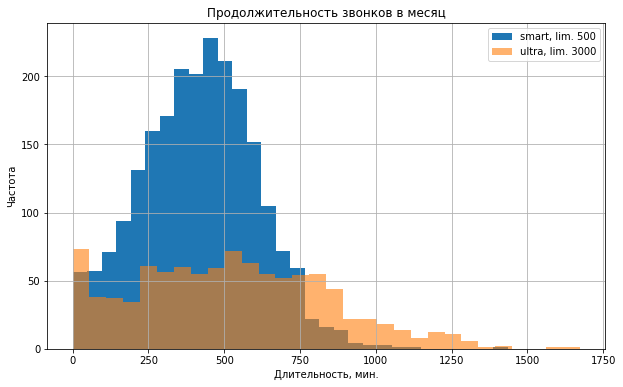

In [27]:
full_report[full_report['tariff'] == 'smart']['duration'].hist(bins = 30, figsize = (10, 6), label = 'smart, lim. 500')
full_report[full_report['tariff'] == 'ultra']['duration'].hist(bins = 30, figsize = (10, 6), alpha = 0.6, label = 'ultra, lim. 3000')
plt.title('Продолжительность звонков в месяц')
plt.xlabel('Длительность, мин.')
plt.ylabel('Частота')
plt.legend()

Судя по гистограмме, чаще всего пользователи тарифа 'smart' тратят от 350 до 500 минут на разговоры в месяц - это ярко выражено на диаграмме. Похоже, что пользователи тарифа 'ultra' чаще пропускают звонки - об этом может говорить пик у нулевой продолжительности звонка. В остальном же, среди пользователей этого тарифа длительность разговоров распределена довольно равномерно - заметных пиков на диаграмме нет.

### Количество интернет-трафика

In [28]:
full_report.groupby('tariff').agg({'mb_used': ['mean', 'var', 'std']})

mb_used                         
            mean            var       std
tariff                                   
smart  16,221.91  34,648,523.30  5,886.30
ultra  19,467.14 102,217,264.28 10,110.26

Абоненты с пакетом 'ultra' в среднем расходуют в месяц примерно на 20% трафика больше. Можно предположить, что пользователи тарифа 'smart' гораздо чаще платят за дополнительные гигабайты, т.к. среднее значение 16222 Мб больше установленного тарифом 15360 Мб. Для тарифа ультра пакет интернет-трафика составляет 30720 Мб, что практически в 1.5 раза больше среднего потребления пользователями тарифа.

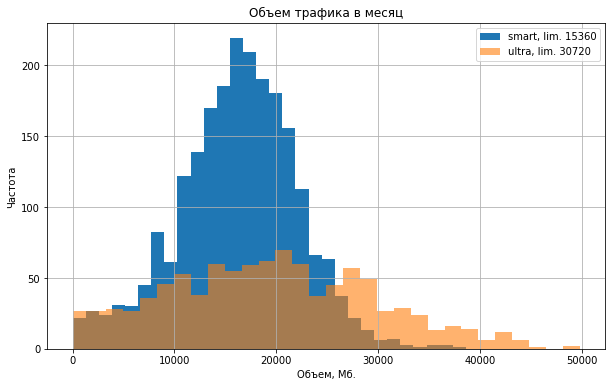

In [29]:
full_report[full_report['tariff'] == 'smart']['mb_used'].hist(bins = 30, figsize = (10, 6), label = 'smart, lim. 15360')
full_report[full_report['tariff'] == 'ultra']['mb_used'].hist(bins = 30, figsize = (10, 6), alpha = 0.6, label = 'ultra, lim. 30720')
plt.title('Объем трафика в месяц')
plt.xlabel('Объем, Мб.')
plt.ylabel('Частота')
plt.legend()

Здесь ситуация подобная звонкам: пользователи с тарифом 'smart' имеют ярко выраженный максимум около 16000 Мб трафика в месяц. Пользователи с тарифом 'ultra' распределились более равномерно, и, в среднем, используют около 20000 Мб трафика в месяц.

### Количество сообщений

In [30]:
full_report.groupby('tariff').agg({'messages': ['mean', 'var', 'std']})

messages               
           mean      var   std
tariff                        
smart     33.37   796.96 28.23
ultra     49.31 2,285.42 47.81

Тарифы имеют ограничения в 50 и 1000 сообщений соответственно. Видно, что ни одно из средних значений не превышает данные лимиты. Соответственно, можно сказать, что пользователи редко платят допольнительно за сообщения. Наглядно это можно подтвердить гистограммой.

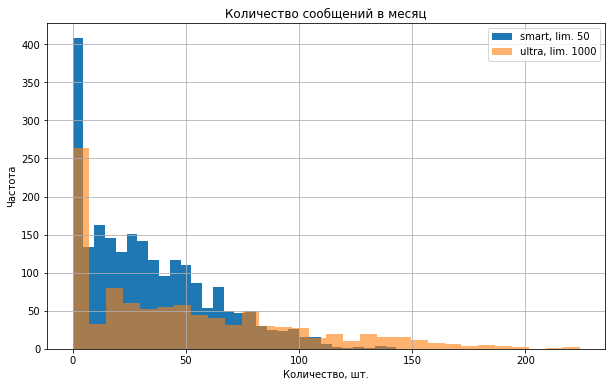

In [31]:
full_report[full_report['tariff'] == 'smart']['messages'].hist(bins = 30, figsize = (10, 6), label = 'smart, lim. 50')
full_report[full_report['tariff'] == 'ultra']['messages'].hist(bins = 30, figsize = (10, 6), alpha = 0.6, label = 'ultra, lim. 1000')
plt.title('Количество сообщений в месяц')
plt.xlabel('Количество, шт.')
plt.ylabel('Частота')
plt.legend()

Видно, что большое количество пользователей вообще не отправляет сообщения, или делает это крайне редко. Похоже, что сообщения приносят меньше всего дополнительного дохода оператору.

### Вывод
Глядя на гистограммы можно сказать, что пользователи тарифа 'ultra' гораздо более равномерно расходуют свой пакет. У пользоватей тарифа 'smart' есть четкие максимумы в расределении - около 500 минут и 15 Гб трафика - что соответствует лимитам их тарифа.<br>
Также можно предположить, что меньше всего дополнительного заработка оператору приносят сверхнормативные сообщения.

## Проверка гипотез
### Сравнение тарифов
Нулевая гипотеза звучит как "средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова". Тогда альтернативная гипотеза будет звучать как "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается". <br>
Задаем критический уровень статистической значимости равным 5%, т.к. это стандартное значение для исследований.

In [32]:
alpha = 0.05

smart_revenue = full_report[full_report['tariff'] == 'smart']['monthly_profit']
ultra_revenue = full_report[full_report['tariff'] == 'ultra']['monthly_profit']

results = st.ttest_ind(smart_revenue, ultra_revenue)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение: 1.7023268870439853e-158
Отвергаем нулевую гипотезу.


Принимаем, что нулевая гипотеза не верна. Судя по p-значению, вероятность равенства средней выручки двух тарифов очень мала. В таком случае, посчитаем среднее значение выручки для каждого тарифа, сравним их и сделаем вывод о прибыльности.

In [33]:
print(f'Среднемесячная выручка тарифа "Smart": {int(smart_revenue.mean())} руб.')
print(f'Среднемесячная выручка тарифа "Ultra": {int(ultra_revenue.mean())} руб.')

Среднемесячная выручка тарифа "Smart": 1294 руб.
Среднемесячная выручка тарифа "Ultra": 2070 руб.


Среднемесячная выручка пользователя тарифа "Ultra" на 37% выше, чем у тарифа "Smart". Очевидно, тратить рекламный бюджет будет выгоднее именно на тариф "Ultra".

### Сравнение Москвы и регионов
Нулевая гипотеза звучит как "средняя выручка пользователей из Москвы равна выручке пользователей из других регионов". В таком случае, альтернативная гипотеза будет звучать как "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". <br>
Критический уровень статистической значимости оставляем равным 5%.

In [34]:
msk_revenue = full_report[full_report['city'] == 'Москва']['monthly_profit']
reg_revenue = full_report[full_report['city'] != 'Москва']['monthly_profit']

results = st.ttest_ind(msk_revenue, reg_revenue)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

p-значение: 0.5277299573181309
Не получилось отвергнуть нулевую гипотезу.


Принимаем решение, что нулевая гипотеза верна - размер ежемесячной выручки пользователя не зависит от региона.

## Общий вывод
В ходе работы были изучены данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Данные в таблицах были приведены к нужным типам, в таблицах были устанены незначительные ошибки.<br>

Проанализировав поведение клиентов, были сделаны выводы:
* Пользователи тарифа 'smart' зачастую тратят в месяц количество минут и гигабайт, близкое к максимуму их тарифа (500 минут и 15 Гб). Это подтверждается гистограммами распределения, имующими пики в этих областях.
* Пользователи тарифа 'ultra' расходуют свои минуты и гигабайты (3000 минут и 30 Гб) равномерно, выдающихся пиков на гистограммах нет. Абоненты редко доходят до лимитов тарифа.
* Сообщения приносят меньше всего дополнительного дохода оператору. На гистограмме есть пики около нуля сообщений в месяц - это говорит о том, что немалая часть пользователей совсем не пользуеся сообщениями или пользуется ими очень мало.
* Гипотеза о различии средней выручки между пользователями тарифов 'smart' и 'ultra' была принята. Пользователи тарифа 'ultra' приносят на 37% больше прибыли.
* Гипотеза о различии выручки между пользователями из Москвы и регионов отвергается.

В итоге, наиболее выгодным для оператора является тариф **'ultra'** - в среднем ежемесячная выручка от него на 37% выше выручки тарифа 'smart', независимо от региона.